<a href="https://colab.research.google.com/github/anas-awadalla/Incepto/blob/master/interpretability_experiments/Image_High_Res_Interpretability_Attribution_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# What I am experimenting with here?
# I am using trying multiple pertubation to find what excites the most (Attribution)
# Averaging the multiple areas to find the specfic objects the NN is looking for
# Comparing that with the OOD Data 

# Based on Ruth C. Fong, Mandela Patrick and Andrea Vedaldi, Understanding Deep Networks via Extremal Perturbations and Smooth Masks, ICCV 2019

In [2]:
!pip install --quiet torchray

     |████████████████████████████████| 378kB 5.5MB/s 


In [3]:
from torchray.attribution.extremal_perturbation import extremal_perturbation, contrastive_reward
from torchray.benchmark import get_example_data, plot_example
from torchray.utils import get_device
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch

In [10]:
transform=transforms.Compose([
            transforms.Resize((224 ,224)),
            transforms.ToTensor()])

In [175]:
model = torchvision.models.inception_v3(pretrained=True)


data = torchvision.datasets.CIFAR10("/content/", train=False,transform=transform , download=True)

dataloader = DataLoader(data, batch_size=1,
                        shuffle=True, num_workers=0)

Files already downloaded and verified


In [61]:
trans = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224,224)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()])

trans_color = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224,224)),
            transforms.ToTensor()])

## Generate Masks

Image Segmentation

In [204]:
import cv2

def remove_background():
    #== Parameters =======================================================================
    BLUR = 5
    CANNY_THRESH_1 = 10
    CANNY_THRESH_2 = 10
    MASK_DILATE_ITER = 20
    MASK_ERODE_ITER = 20
    MASK_COLOR = (0.0,0.0,0.0) # In BGR format

    #== Processing =======================================================================
    img = cv2.imread("img1.png")
    img = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)

    #-- Read image -----------------------------------------------------------------------
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    #-- Edge detection -------------------------------------------------------------------
    edges = cv2.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)
    edges = cv2.dilate(edges, None)
    edges = cv2.erode(edges, None)

    #-- Find contours in edges, sort by area ---------------------------------------------
    contour_info = []
    contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    for c in contours:
        contour_info.append((
            c,
            cv2.isContourConvex(c),
            cv2.contourArea(c),
        ))
    contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)


    #-- Create empty mask, draw filled polygon on it corresponding to largest contour ----
    # Mask is black, polygon is white
    mask = np.zeros(edges.shape)
    for c in contour_info:
        cv2.fillConvexPoly(mask, c[0], (255))
    # cv2.fillConvexPoly(mask, max_contour[0], (255))

    #-- Smooth mask, then blur it --------------------------------------------------------
    mask = cv2.dilate(mask, None, iterations=MASK_DILATE_ITER)
    mask = cv2.erode(mask, None, iterations=MASK_ERODE_ITER)
    mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)
    mask_stack = np.dstack([mask]*3)    # Create 3-channel alpha mask

    #-- Blend masked img into MASK_COLOR background --------------------------------------
    mask_stack  = mask_stack.astype('float32') / 255.0          # Use float matrices, 
    img         = img.astype('float32') / 255.0                 #  for easy blending

    masked = (mask_stack * img) + ((1 - mask_stack) * MASK_COLOR) # Blend
    masked = (masked * 255).astype('uint8')                     # Convert back to 8-bit 
    cv2.imwrite('img.png', masked)
    return masked

In [ ]:
remove_background()

In [ ]:
from torchvision.utils import save_image

results = []
device = get_device()
model.to(device).eval()
area = 0.1

for x,y in tqdm(dataloader):
  
  x = x.to(device)
  if y.item() == 5:
    # Extremal perturbation
    masks_1,_ = extremal_perturbation(
        model, x, y.item(),
        reward_func=contrastive_reward,
        perturbation="blur",
        debug=False,
        areas=[area],
        smooth=0.01,
        max_iter=800
    )

    ## Crop Important Area
    dat=torch.round(masks_1)[0].cpu().detach().numpy() # 'sharpen' mask
    true_points = np.argwhere(dat)
    if len(true_points) != 0:
      # take the smallest points and use them as the top left of your crop
      top_left = true_points.min(axis=0)
      # take the largest points and use them as the bottom right of your crop
      bottom_right = true_points.max(axis=0)
      x = x.squeeze()
      save_image(x, 'org.png')
      out = x[:,top_left[1]:bottom_right[1], 
                top_left[2]:bottom_right[2]]
      out =  torch.tensor(out, dtype=torch.float)
      save_image(out, 'img1.png')
      out = remove_background()
      out = cv2.Canny(out,10,90)

      results.append(torch.tensor(out, dtype=torch.float))
     

Get Representations for Clustering

In [290]:
color = []
for i in tqdm(range(len(results))):
  color.append(trans_color(results[i]).cpu().detach().numpy())
  results[i] = torch.flatten(trans(results[i]), start_dim=1).cpu().detach().numpy()

X1 = torch.flatten(torch.tensor(results), start_dim=1).cpu().detach().numpy()

In [291]:
#Sanity check
X = X1
print ("The shape of X is " + str(X.shape))

The shape of X is (16, 50176)


In [292]:
# To perform PCA we must first change the mean to 0 and variance to 1 for X using StandardScalar
Clus_dataSet = StandardScaler().fit_transform(X) #(mean = 0 and variance = 1)

In [293]:
from sklearn.decomposition import PCA
# Make an instance of the Model
variance = 2
pca = PCA(variance)

In [294]:
#fit the data according to our PCA instance
pca.fit(Clus_dataSet)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [295]:
print("Number of components before PCA  = " + str(X.shape[1]))
print("Number of components after PCA 0.98 = " + str(pca.n_components_))

Number of components before PCA  = 50176
Number of components after PCA 0.98 = 2


In [213]:
#Transform our data according to our PCA instance
Clus_dataSet = pca.transform(Clus_dataSet)

In [214]:
print("Dimension of our data after PCA  = " + str(Clus_dataSet.shape))

Dimension of our data after PCA  = (55, 2)


In [ ]:
#To visualise the data inversed from PCA
approximation = pca.inverse_transform(Clus_dataSet)
print("Dimension of our data after inverse transforming the PCA  = " + str(approximation.shape))

In [297]:
from sklearn.metrics import silhouette_score

sil = []

ideal = None
max = float('-inf')
x = Clus_dataSet

for k in range(2,3):
  kmeans = KMeans(init = "k-means++",n_clusters = k, n_init = 35, max_iter=1000).fit(x)
  labels = kmeans.labels_
  score = silhouette_score(x, labels, metric = 'euclidean')
  if(score > max):
    max = score
    ideal = kmeans

In [298]:
k_means = ideal
print(k_means)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
       n_clusters=2, n_init=35, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)


In [299]:
k_means_labels = k_means.labels_ #List of labels of each dataset
print("The list of labels of the clusters are " + str(np.unique(k_means_labels)))

The list of labels of the clusters are [0 1]


In [300]:
k_means_cluster_centers = k_means.cluster_centers_ #numpy array of cluster centers
k_means_cluster_centers.shape #comes from 10 clusters and 420 features

(2, 50176)

In [301]:
k_means.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int32)

In [302]:
#Find average "image" for each cluster
clusters = {}
for i,j in zip(k_means.labels_,color) :
  if i in clusters.keys():
    clusters.get(i).append(j)
    # clusters.update({i:clusters.get(i).append(j)})
  else:
    clusters.update({i:[j]})

## Use Chi^2 Similarity for Comparisons

In [303]:
import cv2

def get_similar(arr):
  chosen = arr[0]
  x = {}
  for i in range(len(arr)):
    x.update({i: cv2.compareHist(np.array(chosen, dtype=np.float32), np.array(arr[i], dtype=np.float32), 2)})
  x = {k: v for k, v in sorted(x.items(), key=lambda item: item[1])}
  return (x.keys())
    


In [304]:
def choose_sim(arr,target,ratio):
  threshold = int(len(arr)*ratio)
  arr = arr[threshold:]
  result = []
  for i in range(len(target)):
    if(i in arr):
      result.append(target[i])
    
  return result

## Use Highest Activation

## Find visualization by individual pixel comparisons

In [349]:
def get_representation(arr):
  li = []
  for i in range(224):
    li.append([])
    for j in range(224):
      dist = {0:0,1:0}
      for img in arr:
        pixel = img[0][i][j]
        if pixel > 0:
          pixel = 1
        else:
          pixel = 0
        dist.update({pixel:dist.get(pixel)+1})
      if(dist.get(0)>dist.get(1)):
        li[i].append(0)
      else:
        li[i].append(1)
  return li



## Visualize Results

224 224
224 224


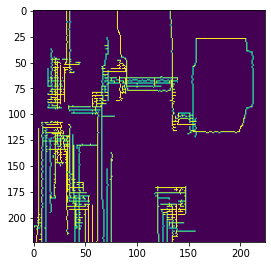

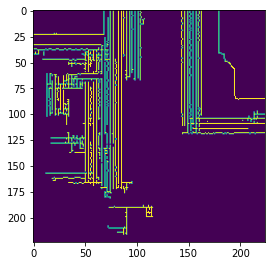

In [353]:
import matplotlib.pyplot as plt
from scipy import ndimage
import cv2

i = 0
for key in clusters.keys():
  fig = plt.figure(figsize=(40,40))    
  ax = fig.add_subplot(8, 8, i + 1)
  arr = get_similar(clusters.get(key))
  arr = choose_sim(list(arr),clusters.get(key),0.9)
  arr = get_representation(arr)
  print(len(arr),len(arr[0]))
  img = np.asarray(torch.tensor(arr).cpu().squeeze().detach().numpy() )
  filter_blurred_f = ndimage.gaussian_filter(img, 1)
  alpha = 4
  sharpened = img + alpha * (img - filter_blurred_f)
  ax.imshow(sharpened)
  i += 1
plt.show()


## Compare Texture

In [ ]:
def compare_texture(src,img):
  return cv2.compareHist(np.array(src, dtype=np.float32), np.array(img, dtype=np.float32), 2)

## Single Image High Resolution

In [235]:
!git clone https://github.com/krasserm/super-resolution.git

fatal: destination path 'super-resolution' already exists and is not an empty directory.


In [236]:
!cp -r super-resolution/model/ /content/
!cp super-resolution/common.py /content/
!cp super-resolution/utils.py /content/

In [ ]:
from model.srgan import generator
from utils import load_image, plot_sample
from common import resolve_single

model_hr = generator()
model_hr.load_weights('/content/drive/My Drive/Interpretability Experiments/srgan_weights/srgan/gan_generator.h5')

lr = load_image('org.png')[:,:,:3]
sr = resolve_single(model_hr, lr)

plot_sample(lr, sr)
